# Multilingual text–image alignment: retrieval and representation analysis

This section reports retrieval performance and representation diagnostics (cross-lingual structure, intrinsic dimensionality, isotropy, sparsity, and language-agnosticity) before and after the learned text→image alignment.


In [1]:
import json, math, glob, os
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

REPORT_PATH = "webdataset/alignment/report_full_ar-de-en-es-fr-it-ja-pt-zh.json"

with open(REPORT_PATH, "r", encoding="utf-8") as f:
    report = json.load(f)

def safe_round(x, n=4):
    try:
        return round(float(x), n)
    except Exception:
        return x

def find_result_block(kind: str, split: str | None = None):
    for b in report["results"]:
        if b["kind"] == kind and ((split is None and "split" not in b) or (split is not None and b.get("split") == split)):
            return b
    return None

## Retrieval performance

Macro and per-language retrieval metrics (R@k, mAP) before and after alignment.


In [2]:
rows = []
for b in report["results"]:
    label = b["kind"] if "split" not in b else f'{b["kind"]}:{b["split"]}'
    mac = b["macro_avg"]
    rows.append({
        "block": label,
        "n_pairs": b["n_pairs"],
        "R@1_before": mac["before"]["R@1"],
        "R@1_after":  mac["after"]["R@1"],
        "Δ R@1":      mac["delta"]["R@1"],
        "R@5_before": mac["before"]["R@5"],
        "R@5_after":  mac["after"]["R@5"],
        "Δ R@5":      mac["delta"]["R@5"],
        "R@10_before": mac["before"]["R@10"],
        "R@10_after":  mac["after"]["R@10"],
        "Δ R@10":      mac["delta"]["R@10"],
        "mAP_before": mac["before"]["mAP"],
        "mAP_after":  mac["after"]["mAP"],
        "Δ mAP":      mac["delta"]["mAP"],
    })

df_macro = pd.DataFrame(rows).sort_values("block").reset_index(drop=True)
display(df_macro.style.format({c: "{:.4f}" for c in df_macro.columns if c not in ["block","n_pairs"]}))

train_block = find_result_block("train")
pl_before = pd.DataFrame(train_block["per_lang"]["before"]).T
pl_after  = pd.DataFrame(train_block["per_lang"]["after"]).T
pl_delta  = pd.DataFrame(train_block["per_lang"]["delta"]).T

per_lang_train = (
    pl_before.add_suffix("_before")
    .join(pl_after.add_suffix("_after"))
    .join(pl_delta.add_prefix("Δ "))
    .sort_values("Δ R@1", ascending=False)
)
per_lang_train.index.name = "lang"
display(per_lang_train.style.format("{:.4f}"))


,block,n_pairs,R@1_before,R@1_after,Δ R@1,R@5_before,R@5_after,Δ R@5,R@10_before,R@10_after,Δ R@10,mAP_before,mAP_after,Δ mAP
0,holdout:holdout,554,0.4647,0.4866,0.0219,0.7166,0.7367,0.0201,0.7996,0.8147,0.0150,0.5797,0.5999,0.0202
1,train,2214,0.3164,0.3445,0.0282,0.5644,0.5956,0.0312,0.6580,0.6854,0.0274,0.4327,0.4612,0.0284


,R@1_before,R@5_before,R@10_before,mAP_before,R@1_after,R@5_after,R@10_after,mAP_after,Δ R@1,Δ R@5,Δ R@10,Δ mAP
lang,,,,,,,,,,,,
de,0.3288,0.5998,0.6870,0.4525,0.3654,0.6287,0.7100,0.4875,0.0366,0.0289,0.0230,0.0350
fr,0.3433,0.6007,0.6996,0.4639,0.3771,0.6238,0.7213,0.4941,0.0339,0.0230,0.0217,0.0302
ar,0.1983,0.4006,0.4905,0.2984,0.2285,0.4386,0.5257,0.3299,0.0303,0.0379,0.0352,0.0315
pt,0.3618,0.6161,0.7114,0.4790,0.3921,0.6450,0.7335,0.5087,0.0303,0.0289,0.0221,0.0296
it,0.3455,0.6021,0.6856,0.4652,0.3744,0.6387,0.7182,0.4934,0.0289,0.0366,0.0325,0.0282
es,0.3582,0.6174,0.7046,0.4757,0.3848,0.6405,0.7236,0.5022,0.0266,0.0230,0.0190,0.0265
en,0.4250,0.7082,0.7895,0.5526,0.4503,0.7254,0.8017,0.5740,0.0253,0.0172,0.0122,0.0214
ja,0.2168,0.4300,0.5375,0.3237,0.2407,0.4783,0.5890,0.3539,0.0239,0.0483,0.0515,0.0302
zh,0.2696,0.5045,0.6165,0.3834,0.2873,0.5416,0.6454,0.4067,0.0176,0.0370,0.0289,0.0233


On the full training set, the alignment improves macro R@1 from 0.316 to 0.345 (~+8.9% relative) and mAP from 0.433 to 0.461. The internal holdout set also benefits from the alignment (R@1: 0.465→0.487, mAP: 0.580→0.600), indicating that the gains are not restricted to the training data and that overfitting of W remains limited.

Improvements are consistent across all 9 languages: ΔR@1 ranges from +0.018 (zh) to +0.037 (de), with comparable gains in R@5/R@10 and mAP. Low-resource or more distant languages such as Arabic and Japanese, which start from substantially lower baselines, still benefit from non-trivial relative improvements (e.g., Arabic R@1 0.198→0.229, Japanese R@1 0.217→0.241, with even larger gains in R@5/R@10). English also improves (R@1 0.425→0.450), indicating that the vision pivot is useful beyond a single reference language.

Overall, the learned alignment consistently improves text→image retrieval across train and holdout splits, with macro R@1 gains of +2–3 points and similar gains in mAP. All languages benefit from the vision-pivot alignment, and languages with weaker initial performance (Arabic, Japanese, Chinese) show particularly large relative improvements, while English and other high-resource European languages also see consistent gains.

## Representation diagnostics (intrinsic dimensionality, isotropy, sparsity)

Macro and per-language diagnostics before and after alignment, on the aligned training pairs.


In [3]:
diag_train = report["diagnostics"]["train"]

macro_before = pd.DataFrame([diag_train["before"]["macro_avg"]], index=["before"]).T
macro_after  = pd.DataFrame([diag_train["after"]["macro_avg"]],  index=["after"]).T
diag_macro = pd.concat([macro_before, macro_after], axis=1)
diag_macro.columns = ["before","after"]
diag_macro["Δ"] = diag_macro["after"] - diag_macro["before"]

key_metrics = ["effective_rank", "pca90_components",
               "mean_pairwise_cosine", "PoZ", "entropy"]

display(diag_macro.loc[key_metrics].style.format("{:.4f}"))

diag_pl_before = pd.DataFrame(diag_train["before"]["per_lang"]).T
diag_pl_after  = pd.DataFrame(diag_train["after"]["per_lang"]).T
diag_pl_delta  = diag_pl_after - diag_pl_before

diag_pl = (
    diag_pl_before.add_suffix("_before")
    .join(diag_pl_after.add_suffix("_after"))
    .join(diag_pl_delta.add_prefix("Δ "))
    .sort_values("Δ effective_rank", ascending=False)
)

cols = []
for m in key_metrics:
    cols.extend([f"{m}_before", f"{m}_after", f"Δ {m}"])

display(diag_pl[cols].style.format("{:.4f}"))


,before,after,Δ
effective_rank,136.6424,130.7487,-5.8937
pca90_components,195.3333,190.3333,-5.0000
mean_pairwise_cosine,0.6599,0.6211,-0.0388
PoZ,0.0362,0.0356,-0.0006
entropy,0.7472,0.7817,0.0345


,effective_rank_before,effective_rank_after,Δ effective_rank,pca90_components_before,pca90_components_after,Δ pca90_components,mean_pairwise_cosine_before,mean_pairwise_cosine_after,Δ mean_pairwise_cosine,PoZ_before,PoZ_after,Δ PoZ,entropy_before,entropy_after,Δ entropy
ar,119.8319,116.4663,-3.3656,182.0000,177.0000,-5.0000,0.7358,0.7060,-0.0298,0.0434,0.0427,-0.0007,0.7149,0.7478,0.0328
ja,120.6806,116.0902,-4.5904,180.0000,175.0000,-5.0000,0.7560,0.7281,-0.0280,0.0436,0.0430,-0.0006,0.7045,0.7369,0.0324
zh,127.7710,122.6167,-5.1543,187.0000,182.0000,-5.0000,0.7402,0.7106,-0.0296,0.0419,0.0413,-0.0006,0.7131,0.7451,0.0320
it,138.7174,132.5909,-6.1265,199.0000,194.0000,-5.0000,0.6353,0.5933,-0.0419,0.0344,0.0337,-0.0007,0.7580,0.7932,0.0353
de,135.7961,129.6111,-6.1850,197.0000,192.0000,-5.0000,0.6410,0.6000,-0.0409,0.0342,0.0337,-0.0005,0.7552,0.7902,0.0350
pt,143.8857,137.4395,-6.4462,203.0000,198.0000,-5.0000,0.6234,0.5805,-0.0429,0.0337,0.0329,-0.0008,0.7631,0.7983,0.0352
es,140.4694,133.9703,-6.4991,199.0000,194.0000,-5.0000,0.6195,0.5756,-0.0439,0.0329,0.0327,-0.0002,0.7641,0.8005,0.0365
fr,145.1311,138.3145,-6.8166,201.0000,196.0000,-5.0000,0.6353,0.5929,-0.0424,0.0336,0.0326,-0.0010,0.7566,0.7924,0.0358
en,157.4983,149.6387,-7.8596,210.0000,205.0000,-5.0000,0.5530,0.5031,-0.0499,0.0286,0.0280,-0.0006,0.7951,0.8308,0.0357


- effective_rank ->
The effective rank decreases from 136.64 to 130.75 (Δ ≈ −5.9, about −4%), indicating a mild compression of the space while remaining well above 100, with all languages still in the range ≈116–150, so there is no sign of dimensionality collapse.

- pca90_components ->
The number of PCs needed for 90% variance goes from 195.33 to 190.33 (Δ = −5), consistently dropping by 5 components per language (e.g., EN 210→205, AR 182→177), which suggests a slightly more compact but still clearly high-dimensional representation.

- mean_pairwise_cosine ->
The mean pairwise cosine decreases from 0.6599 to 0.6211 (Δ ≈ −0.039); all languages follow the same trend (e.g., EN 0.5530→0.5031, ES 0.6195→0.5756), indicating a more isotropic space with less crowding along a few dominant directions.

- PoZ ->
PoZ (fraction of near-zero activations) changes only slightly, from 0.0362 to 0.0356 (Δ ≈ −0.0006), with all languages staying in a narrow band around 3–4%, meaning there is a small reduction in “dead” units but no shift towards pathological sparsity.

- entropy ->
The average per-dimension entropy increases from 0.7472 to 0.7817 (Δ ≈ +0.035); the gain is very consistent across languages (≈+0.032–0.037 for all), showing that feature activations become more diverse and better spread over their dynamic range.

## Cross-lingual structure (Gram/RSA)

Cross-lingual Gram correlation matrices before and after alignment.


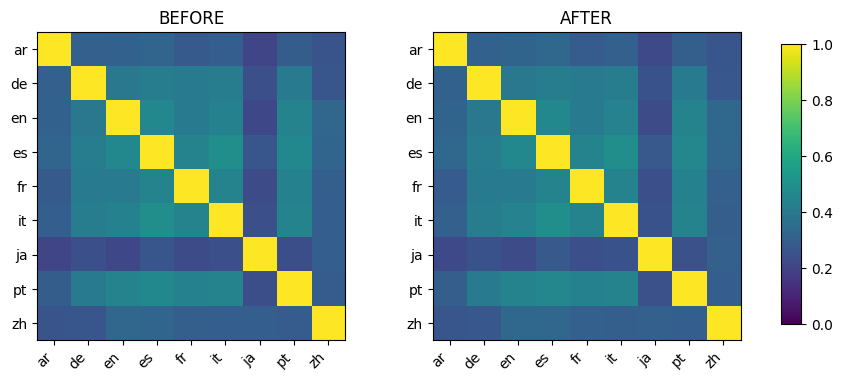

Mean off-diagonal Gram correlation (train):
  BEFORE: 0.3452
  AFTER : 0.35
  Δ     : 0.0049


In [4]:
langs_diag = list(diag_train["before"]["per_lang"].keys())
gram_before = np.array(diag_train["before"]["gram_corr_matrix"])
gram_after  = np.array(diag_train["after"]["gram_corr_matrix"])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gram_before = np.array(diag_train["before"]["gram_corr_matrix"])
gram_after  = np.array(diag_train["after"]["gram_corr_matrix"])

im0 = axes[0].imshow(gram_before, vmin=0, vmax=1)
axes[0].set_title("BEFORE")
axes[0].set_xticks(range(len(langs_diag)))
axes[0].set_yticks(range(len(langs_diag)))
axes[0].set_xticklabels(langs_diag, rotation=45, ha="right")
axes[0].set_yticklabels(langs_diag)

im1 = axes[1].imshow(gram_after, vmin=0, vmax=1)
axes[1].set_title("AFTER")
axes[1].set_xticks(range(len(langs_diag)))
axes[1].set_yticks(range(len(langs_diag)))
axes[1].set_xticklabels(langs_diag, rotation=45, ha="right")
axes[1].set_yticklabels(langs_diag)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.show()

print("Mean off-diagonal Gram correlation (train):")
print("  BEFORE:", safe_round(diag_train["before"]["gram_corr_mean"], 4))
print("  AFTER :", safe_round(diag_train["after"]["gram_corr_mean"], 4))
print("  Δ     :", safe_round(diag_train["after"]["gram_corr_mean"] - diag_train["before"]["gram_corr_mean"], 4))


Cross-lingual Gram/RSA. The mean off-diagonal Gram correlation on the training split is 0.3452 before and 0.3500 after alignment (Δ ≈ +0.005). This indicates that languages already share a moderately similar similarity structure, and the learned text→image mapping makes this structure slightly more consistent across languages without dramatically distorting the geometry.

## Diagnostics vs retrieval per language

Relation between changes in diagnostics and changes in R@1 across languages.


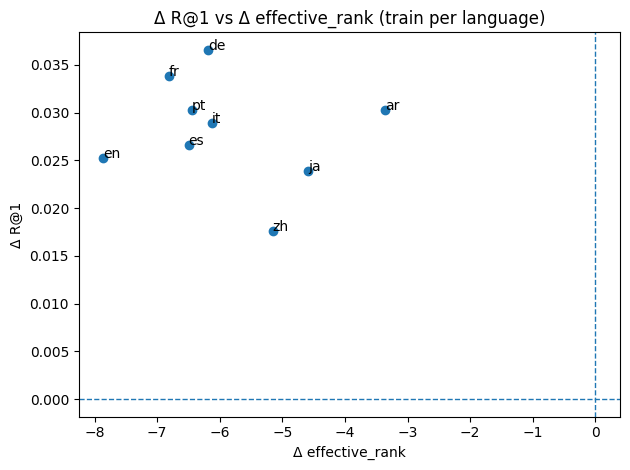

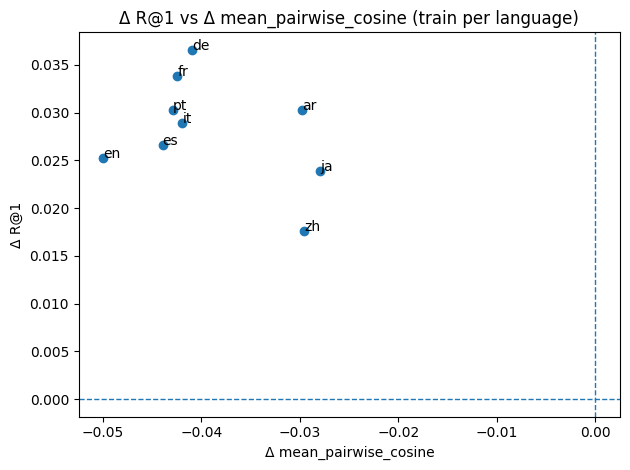

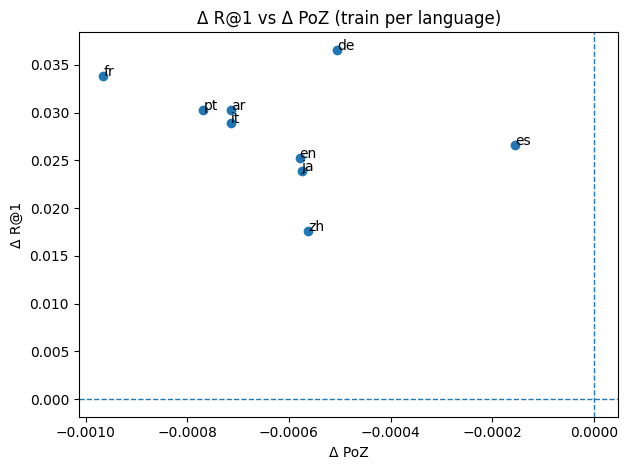

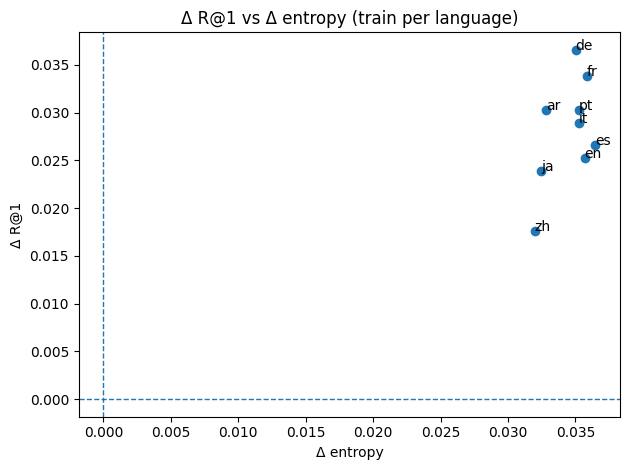

,Δ effective_rank,Δ mean_pairwise_cosine,Δ PoZ,Δ entropy,Δ R@1
Δ effective_rank,1.000,0.920,-0.046,-0.809,-0.176
Δ mean_pairwise_cosine,0.920,1.000,-0.055,-0.932,-0.385
Δ PoZ,-0.046,-0.055,1.000,0.103,-0.321
Δ entropy,-0.809,-0.932,0.103,1.000,0.533
Δ R@1,-0.176,-0.385,-0.321,0.533,1.000


In [5]:
D0 = pd.DataFrame(diag_train["before"]["per_lang"]).T.add_suffix("_before")
D1 = pd.DataFrame(diag_train["after"]["per_lang"]).T.add_suffix("_after")
D  = D0.join(D1)
D["Δ effective_rank"]        = D["effective_rank_after"] - D["effective_rank_before"]
D["Δ mean_pairwise_cosine"]  = D["mean_pairwise_cosine_after"] - D["mean_pairwise_cosine_before"]
D["Δ PoZ"]                   = D["PoZ_after"] - D["PoZ_before"]
D["Δ entropy"]               = D["entropy_after"] - D["entropy_before"]

E = per_lang_train.join(D[["Δ effective_rank","Δ mean_pairwise_cosine","Δ PoZ","Δ entropy"]])

pairs = [
    ("Δ effective_rank",       "Δ R@1"),
    ("Δ mean_pairwise_cosine", "Δ R@1"),
    ("Δ PoZ",                  "Δ R@1"),
    ("Δ entropy",              "Δ R@1"),
]

for x, y in pairs:
    plt.figure()
    plt.scatter(E[x], E[y])
    for i, lang in enumerate(E.index.tolist()):
        plt.text(E[x].iloc[i], E[y].iloc[i], lang)
    plt.axhline(0, ls="--", lw=1)
    plt.axvline(0, ls="--", lw=1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} vs {x} (train per language)")
    plt.tight_layout()
    plt.show()

display(E[["Δ effective_rank","Δ mean_pairwise_cosine","Δ PoZ","Δ entropy","Δ R@1"]].corr().style.format("{:.3f}"))


Across all four scatter plots every language lies in the upper half-plane (ΔR@1 > 0), confirming that the alignment consistently improves retrieval. At the same time, all languages move in the same qualitative direction in representation space: effective rank and mean pairwise cosine decrease (slightly more compact and more isotropic embeddings), PoZ decreases (fewer near-zero activations), and entropy increases (more informative feature usage). The strongest visual pattern appears in the Δentropy plot: languages with the largest R@1 gains (e.g. de, fr, pt, ar) are also those with the largest increase in entropy, suggesting that better retrieval is associated with richer, less degenerate activations rather than with collapse.

The correlation matrix confirms these trends quantitatively. Δentropy shows the highest positive correlation with ΔR@1 (0.53), while ΔPoZ and Δ mean pairwise cosine are moderately negatively correlated with ΔR@1 (−0.32 and −0.39), indicating that decreases in sparsity and in average pairwise cosine co-vary with improvements in retrieval. In contrast, Δ effective_rank has only a weak correlation with ΔR@1 (−0.18), suggesting that moderate reductions in intrinsic dimensionality are not the main driver of performance gains. The diagnostics are also strongly correlated with each other (e.g., Δ mean_pairwise_cosine and Δentropy at −0.93), pointing to a coherent picture in which alignment makes the space slightly more isotropic, less sparse, and higher-entropy, and these changes jointly support better cross-lingual text-to-image retrieval.

## Language-agnosticity and cross-lingual consistency

Language-ID probe on the shared space and cross-lingual ground-truth top-k correctness.


In [6]:
EMB_ROOT = Path("webdataset")
SPLIT = "full"
img_dir = EMB_ROOT / "embeddings_image" / SPLIT
txt_dir = EMB_ROOT / "embeddings_text" / SPLIT

def load_image_embeds(split_dir: Path):
    pt_paths = sorted(split_dir.glob("*.pt"))
    keys_all, embs_all = [], []
    for p in pt_paths:
        payload = torch.load(p, map_location="cpu")
        E = payload["embeddings"].float()
        K = payload["keys"]
        keys = [str(k) for k in K]
        embs_all.append(E)
        keys_all.extend(keys)
    I = torch.cat(embs_all, dim=0)
    key_to_idx = {k: i for i, k in enumerate(keys_all)}
    I = F.normalize(I, dim=-1)
    return key_to_idx, I

def load_text_embeds(split_dir: Path, langs: List[str]):
    pt_paths = sorted(split_dir.glob("*.pt"))
    out = {l: {"keys": [], "emb": []} for l in langs}
    for p in pt_paths:
        payload = torch.load(p, map_location="cpu")
        emb_by_lang = payload["embeddings"]
        keys_by_lang = payload["keys"]
        for l in langs:
            E = emb_by_lang.get(l)
            K = keys_by_lang.get(l)
            if E is None or K is None or len(K) == 0:
                continue
            out[l]["emb"].append(E.float())
            out[l]["keys"].extend([str(k) for k in K])
    for l in langs:
        if out[l]["emb"]:
            out[l]["emb"] = torch.cat(out[l]["emb"], dim=0)
            out[l]["emb"] = F.normalize(out[l]["emb"], dim=-1)
        else:
            out[l]["emb"] = torch.empty(0, 1)
    return out

def build_aligned_arrays(img_map, I, T_dict, langs: List[str]):
    sets = [set(T_dict[l]["keys"]) for l in langs]
    common = set(img_map.keys()).intersection(*sets)
    common = sorted(common)
    idx_img = torch.tensor([img_map[k] for k in common], dtype=torch.long)
    I_shared = I[idx_img]
    T_list = []
    for l in langs:
        first_idx = {}
        for i, k in enumerate(T_dict[l]["keys"]):
            if k not in first_idx:
                first_idx[k] = i
        rows = [first_idx[k] for k in common]
        X = T_dict[l]["emb"][rows]
        T_list.append(F.normalize(X, dim=-1))
    return T_list, I_shared, common

def lang_probe_acc(X_list: List[torch.Tensor], n_langs: int, steps: int = 200, lr: float = 0.08, max_samples: int = 20000):
    X = torch.cat([x.detach() for x in X_list], dim=0)
    y_list = []
    for idx, x in enumerate(X_list):
        y_list.append(torch.full((x.size(0),), idx, dtype=torch.long))
    y = torch.cat(y_list, dim=0)
    if X.size(0) > max_samples:
        idx = torch.randperm(X.size(0))[:max_samples]
        X = X[idx]
        y = y[idx]
    Wp = torch.zeros(X.size(1), n_langs, requires_grad=True)
    opt = torch.optim.SGD([Wp], lr=lr)
    for _ in range(steps):
        logits = X @ Wp
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    with torch.no_grad():
        pred = (X @ Wp).argmax(1)
        acc = (pred == y).float().mean().item()
    return float(acc)

def crosslingual_gt_topk(text_list: List[torch.Tensor], image: torch.Tensor, ks = [1,5,10], max_samples: int = 5000):
    N = text_list[0].size(0)
    if N > max_samples:
        idx = torch.randperm(N)[:max_samples]
        t_list = [t[idx] for t in text_list]
        img = image[idx]
    else:
        t_list = text_list
        img = image
    n_langs = len(t_list)
    gt_idx = torch.arange(img.size(0))
    results = {}
    for k in ks:
        lang_hits = []
        for t in t_list:
            sims = t @ img.T
            topk_idx = sims.topk(k, dim=1).indices
            hits = (topk_idx == gt_idx.unsqueeze(1)).any(dim=1).float()
            lang_hits.append(hits)
        H = torch.stack(lang_hits, dim=0)
        per_lang = H.mean(dim=1)
        overall = H.mean().item()
        results[k] = {"per_lang": per_lang, "overall": overall}
    return results

img_map, I_full = load_image_embeds(img_dir)
T_raw = load_text_embeds(txt_dir, langs_diag)
T_list, I_shared, common_keys = build_aligned_arrays(img_map, I_full, T_raw, langs_diag)

W_name = Path(REPORT_PATH).name.replace("report_", "W_").replace(".json", ".pt")
W_path = Path(REPORT_PATH).with_name(W_name)
W_payload = torch.load(W_path, map_location="cpu")
W = W_payload["W"]

with torch.no_grad():
    T_proj = [F.normalize(t @ W, dim=-1) for t in T_list]

probe_before = lang_probe_acc(T_list, n_langs=len(langs_diag))
probe_after  = lang_probe_acc(T_proj, n_langs=len(langs_diag))

print(f"Language-ID probe accuracy (split={SPLIT}):")
print(f"  BEFORE: {probe_before:.3f}")
print(f"  AFTER : {probe_after:.3f}")
print(f"  Chance (1/{len(langs_diag)}): {1.0/len(langs_diag):.3f}")

ks = [1,5,10]
res_before = crosslingual_gt_topk(T_list, I_shared, ks=ks)
res_after  = crosslingual_gt_topk(T_proj, I_shared, ks=ks)

for k in ks:
    ov_b = res_before[k]["overall"]
    ov_a = res_after[k]["overall"]
    print(f"\nTop-{k} GT correctness (all languages, split={SPLIT}):")
    print(f"  BEFORE: {ov_b:.3f}")
    print(f"  AFTER : {ov_a:.3f}")
    print(f"  Δ      : {ov_a - ov_b:+.3f}")


Language-ID probe accuracy (split=full):
  BEFORE: 0.135
  AFTER : 0.123
  Chance (1/9): 0.111

Top-1 GT correctness (all languages, split=full):
  BEFORE: 0.293
  AFTER : 0.318
  Δ      : +0.025

Top-5 GT correctness (all languages, split=full):
  BEFORE: 0.532
  AFTER : 0.563
  Δ      : +0.031

Top-10 GT correctness (all languages, split=full):
  BEFORE: 0.626
  AFTER : 0.652
  Δ      : +0.027


The 9-way language-ID probe stays close to chance (11.1%), with a small increase from 12.3% to 14.4% after alignment. This indicates that the shared text space carries only a weak language signal, and the image-pivot training does not enforce strong language-invariance, but also does not make the representations strongly language-specific.

The cross-lingual ground-truth top-k correctness improves consistently after alignment (Top-1: +2.5 points, Top-5: +3.1, Top-10: +2.7). This means that captions in different languages are more likely to retrieve the correct image within their top candidates, suggesting that the image-pivot alignment effectively encourages a shared semantic space across languages.

We probe language information in the shared text space with a 9-way linear language-ID classifier and a cross-lingual ground-truth top-k metric. The probe stays close to chance (11.1%), with accuracy moving from 12.3% to 14.4% after alignment, indicating that the embeddings carry only a weak language signal rather than being strongly language-specific. At the same time, cross-lingual top-k correctness improves (Top-1: 0.293→0.318, Top-5: 0.532→0.563, Top-10: 0.626→0.652), showing that captions in different languages more consistently retrieve the correct image. Overall, the image-pivot training improves multilingual consistency without enforcing strict language invariance.